# Debugging a pipeline

`river` encourages users to make use of pipelines. The biggest pain point of pipelines is that it can be hard to understand what's happening to the data, especially when the pipeline is complex. Fortunately the `Pipeline` class has a `debug_one` method that can help out.

Let's look at a fairly complex pipeline for predicting the number of bikes in 5 bike stations from the city of Toulouse. It doesn't matter if you understand the pipeline or not; the point of this notebook is to learn how to introspect a pipeline.

In [1]:
import datetime as dt
from river import compose
from river import datasets
from river import feature_extraction
from river import linear_model
from river import metrics
from river import preprocessing
from river import stats
from river import stream


X_y = datasets.Bikes()
X_y = stream.simulate_qa(X_y, moment='moment', delay=dt.timedelta(minutes=30))

def add_time_features(x):
    return {
        **x,
        'hour': x['moment'].hour,
        'day': x['moment'].weekday()
    }

model = add_time_features
model |= (
    compose.Select('clouds', 'humidity', 'pressure', 'temperature', 'wind') +
    feature_extraction.TargetAgg(by=['station', 'hour'], how=stats.Mean()) +
    feature_extraction.TargetAgg(by='station', how=stats.EWMean())
)
model |= preprocessing.StandardScaler()
model |= linear_model.LinearRegression()

metric = metrics.MAE()

questions = {}

for i, x, y in X_y:
    # Question
    is_question = y is None
    if is_question:
        y_pred = model.predict_one(x)
        questions[i] = y_pred
    
    # Answer
    else:
        metric.update(y, questions[i])
        model = model.learn_one(x, y)
    
        if i >= 30000 and i % 30000 == 0:
            print(i, metric)

30000 MAE: 2.220942
60000 MAE: 2.270271
90000 MAE: 2.301302
120000 MAE: 2.275876
150000 MAE: 2.275224
180000 MAE: 2.289347


We can start by looking at what the pipeline looks by drawing it.

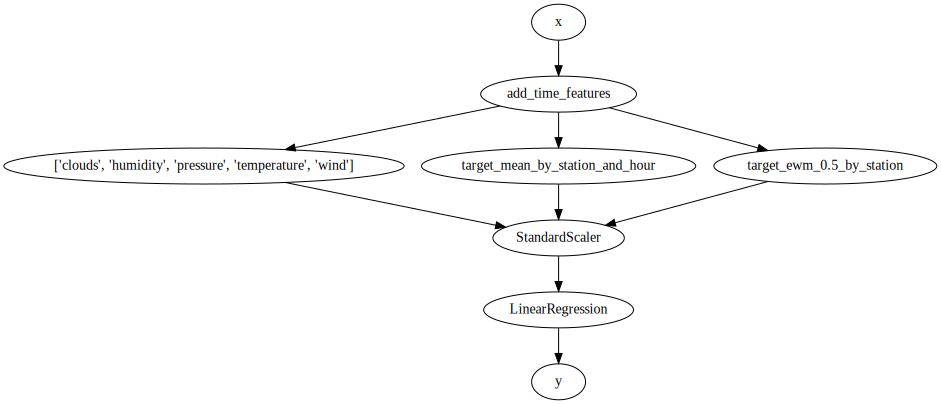

In [2]:
model.draw()

As mentioned above the `Pipeline` class has a `debug_one` method. You can use this at any point you want to visualize what happen to an input `x`. For example, let's see what happens to the last seen `x`.

In [3]:
model.debug_one(x)

'0. Input\n--------\nclouds: 88 (int)\ndescription: overcast clouds (str)\nhumidity: 84 (int)\nmoment: 2016-10-05 09:57:18 (datetime)\npressure: 1,017.34000 (float)\nstation: pomme (str)\ntemperature: 17.45000 (float)\nwind: 1.95000 (float)\n\n1. add_time_features\n--------------------\nclouds: 88 (int)\nday: 2 (int)\ndescription: overcast clouds (str)\nhour: 9 (int)\nhumidity: 84 (int)\nmoment: 2016-10-05 09:57:18 (datetime)\npressure: 1,017.34000 (float)\nstation: pomme (str)\ntemperature: 17.45000 (float)\nwind: 1.95000 (float)\n\n2. Transformer union\n--------------------\n    2.0 Select\n    ----------\n    clouds: 88 (int)\n    humidity: 84 (int)\n    pressure: 1,017.34000 (float)\n    temperature: 17.45000 (float)\n    wind: 1.95000 (float)\n\n    2.1 TargetAgg\n    -------------\n    target_mean_by_station_and_hour: 7.89396 (float)\n\n    2.2 TargetAgg1\n    --------------\n    target_ewm_0.5_by_station: 11.80372 (float)\n\nclouds: 88 (int)\nhumidity: 84 (int)\npressure: 1,017.

The pipeline does quite a few things, but using `debug_one` shows what happens step by step. This is really useful for checking that the pipeline is behaving as you're expecting it too. Remember that you can `debug_one` whenever you wish, be it before, during, or after training a model.